In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import kipoiseq
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from EPInformer.models import EPInformer_v2
from scripts.utils import prepare_input, encoder_promoter_enhancer_CRISPRi

In [3]:
flowfish_df = pd.read_excel('./data/CRISPRi-FlowFISH_Fulco2019/41588_2019_538_MOESM3_ESM.xlsx',sheet_name='Supplementary Table 6a', skiprows=[0])
# ensid_gene = pd.read_csv('./data/CRISPRi-FlowFISH_Fulco2019/GeneName2ENSID.csv')
RNA_feats = pd.read_csv('./data/GM12878_K562_18377_gene_expr_fromXpresso.csv', index_col='Gene stable ID')[['Gene name', 'UTR5LEN_log10zscore','CDSLEN_log10zscore','INTRONLEN_log10zscore','UTR3LEN_log10zscore','UTR5GC','CDSGC','UTR3GC', 'ORFEXONDENSITY_log10zscore']]
ensid_gene = RNA_feats[['Gene name']].reset_index()
flowfish_df['significant_enhancer'] = flowfish_df['Significant']&(flowfish_df['Fraction change in gene expr'] < 0)
flowfish_df = flowfish_df.merge(ensid_gene, left_on='Gene', right_on='Gene name', how='left')
flowfish_df['Xpresso_gene'] = False
intersec_ensid = list(set(flowfish_df['Gene stable ID']).intersection(set(RNA_feats.index)))
flowfish_df = flowfish_df.set_index('Gene stable ID')
flowfish_df.loc[intersec_ensid, 'Xpresso_gene'] = True
flowfish_df = flowfish_df[flowfish_df['Xpresso_gene']].reset_index()
flowfish_df['mid'] = flowfish_df['start'] + (flowfish_df['end'] - flowfish_df['start'])/2
flowfish_df['Distance_withDirect'] = flowfish_df['mid'] - flowfish_df['Gene TSS']
flowfish_df['Distance'] = np.abs(flowfish_df['Distance_withDirect'])
flowfish_100kb_df = flowfish_df[flowfish_df['Distance'] <= 100_000]
flowfish_100kb_df['#true_enhance_by_gene'] = flowfish_100kb_df.groupby('Gene')['significant_enhancer'].transform('sum') #  = 

In [7]:
expr_df = pd.read_csv('./data/GM12878_K562_18377_gene_expr_fromXpresso.csv', index_col='ENSID')[['K562_CAGE_128*3_sum', 'Actual_K562']]
expr_flowfish_100kb_df = expr_df.merge(flowfish_100kb_df, left_index=True, right_on='Gene stable ID', how='right').reset_index()

In [8]:
gene_list = flowfish_100kb_df['Gene name'].dropna().unique()

In [7]:
# def encoder_promoter_enhancer_CRISPRi(pe_df, device='cpu', hg19_fasta_path = '../hg19.fa'):
#     hg19_fasta_extractor = FastaStringExtractor("../hg19.fa")
#     RNA_feats = pd.read_csv('./data/GM12878_K562_18377_gene_expr_fromXpresso.csv', index_col='Gene stable ID')[['UTR5LEN_log10zscore','CDSLEN_log10zscore','INTRONLEN_log10zscore','UTR3LEN_log10zscore','UTR5GC','CDSGC','UTR3GC', 'ORFEXONDENSITY_log10zscore']]
#     promoter_df = pd.read_csv('./data/CRISPRi-FlowFISH_Fulco2019/DNase_ENCFF257HEE_Neighborhoods/GeneList.txt', sep='\t', index_col='symbol')
#     promoter_df['PromoterActivity'] = np.sqrt(promoter_df['H3K27ac.RPM.TSS1Kb']*promoter_df['DHS.RPM.TSS1Kb'])
#     max_n_promoter = len(promoter_df)
#     max_n_enhancer = len(pe_df)
#     max_seq_len = 2000
#     enhancer_distance = np.zeros(max_n_enhancer)
#     enhancer_activity = np.zeros(max_n_enhancer)
#     enhancer_hic = np.zeros(max_n_enhancer)
#     enhancers_code = np.zeros((max_n_enhancer, max_seq_len, 4))
#     e_i = 0
#     ensid = pe_df.iloc[0]['Gene stable ID']
#     singleGene_promoter_activity = promoter_df.loc[ensid, 'PromoterActivity']

#     gene_tss = pe_df.iloc[0]['Gene TSS']
#     gene_name = pe_df.iloc[0]['Gene name']

#     chrom = pe_df.iloc[0]['chr']
#     target_interval = kipoiseq.Interval(chrom, int(gene_tss-max_seq_len/2), int(gene_tss+max_seq_len/2))
#     print(ensid, gene_name, chrom)
#     promoter_seq = hg19_fasta_extractor.extract(target_interval)
#     promoter_code = one_hot_encode(str(promoter_seq))
#     for idx, row in tqdm(pe_df.iterrows()):
#         chrom = row['chr']
#         enhancer_start = int(row['start'])
#         enhancer_end = int(row['end'])
#         enhancer_center = int((enhancer_start + enhancer_end)/2)
#         enhancer_len = enhancer_end - enhancer_start
#         if enhancer_len > 2000:
#             enhancer_start = enhancer_center-1000
#             enhancer_end = enhancer_center+1000
#             enhancer_len = 2000
#         # print(enhancer_len)
#         code_start = int(max_seq_len/2)-int(enhancer_len/2)
#         enhancer_target_interval = kipoiseq.Interval(chrom, enhancer_start, enhancer_end)
#         enhancers_code[e_i][code_start:code_start+enhancer_len] = one_hot_encode(hg19_fasta_extractor.extract(enhancer_target_interval))
#         enhancer_activity[e_i] = row['Activity']
#         enhancer_distance[e_i] = row['Distance']
#         enhancer_hic[e_i] = row['Normalized HiC Contacts']
#         e_i += 1
#         rna_ts = np.array(list(RNA_feats.loc[ensid].values)  + [singleGene_promoter_activity])[np.newaxis,:]

#     # print(rna_ts)
#     pe_code = np.concatenate([promoter_code[np.newaxis], enhancers_code], axis=0)
#     pe_activity = np.concatenate([[0], enhancer_activity]).flatten()
#     pe_hic = np.concatenate([[0], enhancer_hic]).flatten()
#     pe_activity = np.log10(0.1+pe_activity)
#     pe_distance = np.concatenate([[0], enhancer_distance/1000]).flatten()

#     pe_feat = np.concatenate([pe_distance[:,np.newaxis], pe_activity[:,np.newaxis], pe_hic[:,np.newaxis]],axis=-1)
#     seq_ts = torch.from_numpy(pe_code)
#     feat_ts = torch.from_numpy(pe_feat)
#     rna_ts = torch.from_numpy(rna_ts)
#     seq_ts = seq_ts.unsqueeze(0).float().to(device)
#     rna_ts = rna_ts.float().to(device)
#     feat_ts = feat_ts.unsqueeze(0).float().to(device)
#     return seq_ts, feat_ts, rna_ts

In [9]:
def perturb_enhancer(model, pe_df, use_hic=False, device='cpu'):
    pe_df = pe_df.sort_values(by='Distance').reset_index()
    model.eval()
    perturb_pred_list = []
    with torch.no_grad():
      seq_input, feat_input, rna_input = encoder_promoter_enhancer_CRISPRi(pe_df, hg19_fasta_path='../hg19.fa')
      seq_input = torch.from_numpy(seq_input)
      feat_input = torch.from_numpy(feat_input)
      rna_input = torch.from_numpy(rna_input)
      seq_input = seq_input.unsqueeze(0).float().to(device)
      rna_input = rna_input.float().to(device)
      feat_input = feat_input.unsqueeze(0).float().to(device)

      distToTSS = feat_input[:, :, 0].detach().cpu().numpy().flatten()*1000
      signals = feat_input[:, :, 1].detach().cpu().numpy().flatten()
      hic = feat_input[:, :, 2].detach().cpu().numpy().flatten()
      if not use_hic:
          feat_input = feat_input[:, :, :2] # exclude HiC
      else:
          feat_input = torch.cat([feat_input[:,:,:1], feat_input[:,:,2:], feat_input[:,:,1:2]], dim=-1)
      # print(feat_input.shape)
      all_expr, attn_list = model(seq_input, rna_input, feat_input)
      all_expr = all_expr.cpu().detach().numpy()[0][0]
      all_expr = 10**all_expr-1
      # print('predictive expression', all_expr)
      attn_list = attn_list.permute((1, 0, 2, 3))+1e-5
      attn_firstLayer = attn_list[:,0,:][:,0].cpu().detach().numpy()[0]
      attn_meanLayer = attn_list.mean(1)[:,0].cpu().detach().numpy()[0]
      print('Calucuting the change of predicted expression by in-silico perturbation...')
      for mask_ei in tqdm(range(1, len(pe_df)+1)):
          # print(mask_ei)
          seq_perturb = seq_input.clone()
          seq_perturb[:,mask_ei,:, :] = torch.zeros((1, 2000, 4))
          with torch.no_grad():
              pred_expr, _ = model(seq_perturb, rna_input, feat_input)
          pred_expr = pred_expr.cpu().detach().numpy().flatten()[0]
          pred_expr = 10**pred_expr-1
          perturb_pred_list.append(pred_expr)

    perturb_pred_list = np.array(perturb_pred_list)
    pe_df['promoter_attention_mean'] = attn_meanLayer[0]
    pe_df['promoter_attention_layer1'] = attn_firstLayer[0]
    pe_df['change of predicted expression'] = (((perturb_pred_list - all_expr))/all_expr)
    pe_df['in-silico perturb expr'] = perturb_pred_list
    pe_df['distanceToTSS'] = (distToTSS[1:]).astype(int)
    pe_df['enhancer activity'] = 10**signals[1:]-1
    pe_df['HiC contact'] = hic[1:]
    pe_df['Attention mean'] = attn_meanLayer[1:]/sum(attn_meanLayer[1:])
    pe_df['Attention layer1'] = attn_firstLayer[1:]/sum(attn_firstLayer[1:])
    pe_df['pred_expr'] = all_expr
    return pe_df

In [34]:
# in-silco perturbation
gene_name = 'KLF1'
pe_annot_df = expr_flowfish_100kb_df[expr_flowfish_100kb_df['Gene name'] == gene_name]
device = 'cpu'
EPInformer_PE_activity_HiC = EPInformer_v2(n_encoder=3, n_enhancer=len(pe_annot_df), out_dim=64, n_extraFeat=3, device=device, useFeat=True, usePromoterSignal=True, useLN=True)
model_path = './trained_models/EPInformer_PE_Activity_HiC/K562/fold_8_EPInformer_PE_Activity_HiC_CAGE_K562_checkpoint.pt'
checkpoint = torch.load(model_path, map_location=torch.device(device))
EPInformer_PE_activity_HiC.load_state_dict(checkpoint['model_state_dict'])
net = EPInformer_PE_activity_HiC.to(device)
perturb_HiC = perturb_enhancer(EPInformer_PE_activity_HiC, pe_annot_df, use_hic=True)
perturb_HiC.sort_values(by=['Distance_withDirect'], inplace=True)

ENSG00000105610 KLF1 chr19


37it [00:00, 1500.04it/s]


Calucuting the change of predicted expression by in-silico perturbation...


100%|██████████| 37/37 [00:14<00:00,  2.47it/s]


In [35]:
# in-silco perturbation
gene_name = 'KLF1'
pe_annot_df = expr_flowfish_100kb_df[expr_flowfish_100kb_df['Gene name'] == gene_name]
device = 'cpu'
EPInformer_PE_activity = EPInformer_v2(n_encoder=3, n_enhancer=len(pe_annot_df), out_dim=64, n_extraFeat=2, device=device, useFeat=True, usePromoterSignal=True, useLN=True)
model_path = './trained_models/EPInformer_PE_Activity/K562/fold_9_EPInformer_PE_Activity_CAGE_K562_checkpoint.pt'
checkpoint = torch.load(model_path, map_location=torch.device(device))
EPInformer_PE_activity.load_state_dict(checkpoint['model_state_dict'])
EPInformer_PE_activity = EPInformer_PE_activity.to(device)
perturb_noHiC = perturb_enhancer(EPInformer_PE_activity, pe_annot_df, use_hic=False)
perturb_noHiC.sort_values(by=['Distance_withDirect'], inplace=True)

ENSG00000105610 KLF1 chr19


37it [00:00, 1307.59it/s]


Calucuting the change of predicted expression by in-silico perturbation...


100%|██████████| 37/37 [00:14<00:00,  2.59it/s]


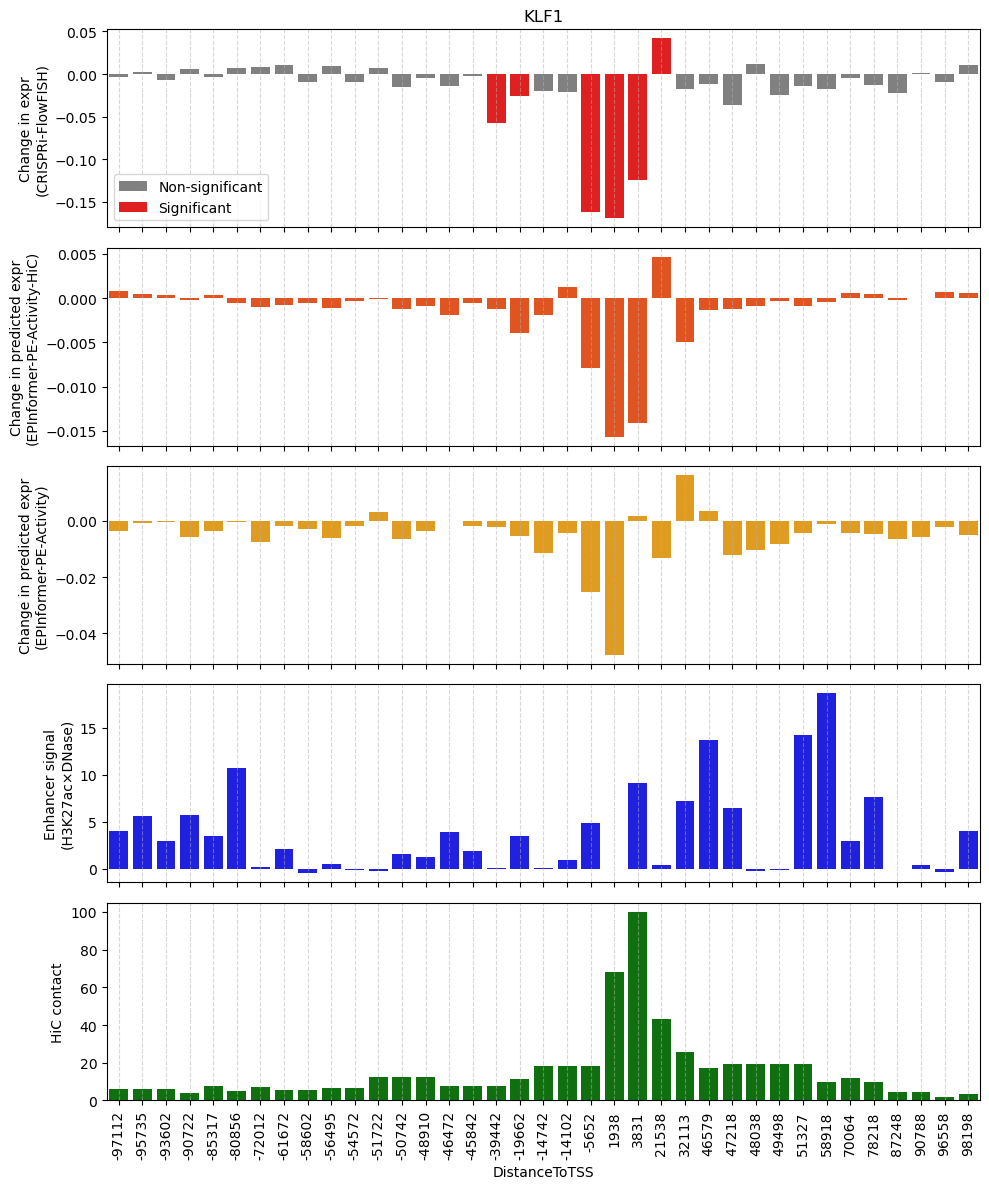

In [36]:
plt.figure(figsize=(10,12))
ax1 = plt.subplot(511)
plt.title('KLF1')
sns.barplot(x='Distance_withDirect', y='Fraction change in gene expr', data=perturb_HiC, ax=ax1, linewidth=0, color='grey', label='Non-significant')
perturb_HiC['EffectSize_significant'] = perturb_HiC['Fraction change in gene expr']*(perturb_HiC['Significant'] == True).astype(int)
sns.barplot(x='Distance_withDirect', y='EffectSize_significant', data=perturb_HiC, ax=ax1, color='red', linewidth=0, label='Significant')
plt.grid(axis='x', ls='--', alpha=0.5)
plt.tick_params('x', labelbottom=False)
plt.xlabel('')
plt.ylabel('Change in expr\n(CRISPRi-FlowFISH)')

ax2 = plt.subplot(512, sharex=ax1)
perturb_HiC['Distance_withDirect'] = perturb_HiC['Distance_withDirect'].astype(int)
sns.barplot(x='Distance_withDirect', y='change of predicted expression', data=perturb_HiC, ax=ax2, linewidth=0, color='orangered')
plt.xlabel('')
plt.ylabel('')
plt.tick_params('x', labelbottom=False)
plt.grid(axis='x', ls='--', alpha=0.5)
plt.ylabel('Change in predicted expr\n(EPInformer-PE-Activity-HiC)')

ax3 = plt.subplot(513, sharex=ax1)
perturb_noHiC['Distance_withDirect'] = perturb_noHiC['Distance_withDirect'].astype(int)
sns.barplot(x='Distance_withDirect', y='change of predicted expression', data=perturb_noHiC, ax=ax3, linewidth=0, color='orange')
plt.xlabel('')
plt.ylabel('')
plt.tick_params('x', labelbottom=False)
plt.grid(axis='x', ls='--', alpha=0.5)
plt.ylabel('Change in predicted expr\n(EPInformer-PE-Activity)')

ax4 = plt.subplot(514, sharex=ax1)
sns.barplot(x='Distance_withDirect', y='enhancer activity', data=perturb_HiC, ax=ax4, linewidth=0, color='blue')
plt.tick_params('x', labelbottom=False)
plt.ylabel('Enhancer signal\n(H3K27ac×DNase)')
plt.grid(axis='x', ls='--', alpha=0.5)
plt.xlabel('')

ax5 = plt.subplot(515, sharex=ax1)
sns.barplot(x='Distance_withDirect', y='HiC contact', data=perturb_HiC, ax=ax5, linewidth=0, color= 'green')
plt.ylabel('HiC contact')
plt.xlabel('DistanceToTSS')

plt.grid(axis='x', ls='--', alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig('./KLF1_insilico_perturbation.pdf', transparent=True)